<!-- JPN -->
# 決定木による分類とモデル評価

※本演習資料の二次配布・再配布はお断り致します。



<!-- ENG -->
# Decision tree classifier and model evaluation

※Distribution or redistribution of these exercise materials without the copyright holder's permission is not permitted.



<!-- JPN -->
　今回の演習の内容は以下の3つである。

**1 | データクレンジング：データの整理**

**2 | 決定木 (decision tree) を用いた分類**

**3 | モデル選択 (model selection)**

　今回から、pandas や NumPy に加えて機械学習用ライブラリである scikit-learn を用いて決定木を構築していく。

<!-- ENG -->
　We will learn the following three things in this exercise.

**1 | Data cleansing: Organizing your data**

**2 | Classification using a decision tree**

**3 | Model selection**

　This time, we will use scikit-learn, a machine learning library, in addition to pandas and NumPy, to build decision trees.

<!-- JPN -->
## 1 | データクレンジング：データの整理

　今回は、タイタニック号の乗客のデータ `titanic.csv` を用いて、沈没事故の際にどのような乗客が生き残ったのかを予測する。
実はこの `titanic.csv` 、用いるデータの情報に一部抜けが存在しているため、まず**データクレンジング**と呼ばれる作業を行う（**補足資料 ※1**）。

<!-- ENG -->
## 1 | Data cleansing: Organizing your data

　Here, we will use the data of the passengers found in the Titanic, `titanic.csv`, to predict which passengers survived the sinking.
In fact, this `titanic.csv` has some missing information in the data, so the first step is a process called **data cleansing** (**Supplementary Material S1**).

<!-- JPN -->
　まず、**`titanic.csv` をGoogle Colaboratoryにアップロードする**。アップロードが終わったら、どんな情報が含まれているデータなのか見てみよう。

<!-- ENG -->
　First, **upload `titanic.csv` to Google Colaboratory**. After uploading is complete, let's take a look at what information the data contains.

In [93]:
import numpy as np
import pandas as pd
#df = pd.read_csv("https://raw.githubusercontent.com/giftedmelon/AdDataSci2023/main/titanic.csv")
df = pd.read_csv("titanic.csv")
pd.set_option("display.max_columns", None) # Setting to display all columns
print(df.head())                           # Display only the first 5 lines

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


<!-- JPN -->
　このデータには、生き残ったかどうかを示す`Survived`と、各乗客の情報が記されている。

　今回は簡単のために、乗客の情報は`Pclass`, `Sex`, `Age`, `Fare`の4種類のみを説明変数 (explanatory variables) として使うことにして、細かく見てみる。

<!-- ENG -->
　This data includes `Survived`, which indicates whether the person survived, and information about each passenger.

　For the sake of simplicity, we will use only four kinds of passenger information as explanatory variables: `Pclass`, `Sex`, `Age`, and `Fare` and look at them in detail.

In [94]:
# Extract only the four explanatory variables and one class label
df = df[["Pclass", "Sex", "Age", "Fare", "Survived"]]

<!-- JPN -->
　まず、ほとんどの機械学習のモデルは説明変数や目的変数 (class label) を**数値**で受け取るので、性別を数値に変換する。このデータでは性別は2種類しかないので、0/1の2値に変換しよう。

<!-- ENG -->
　First, since most machine learning models receive explanatory variables and class labels as **numerical values**, we need to convert gender to a numerical value. There are only two genders in this data, so let's convert it either 0 or 1.

In [95]:
# Create an array: 1 if "male", 0 otherwise, and assign it to X["IsMale"].
is_male = df["Sex"].apply(lambda x: 1 if x == 'male' else 0) # Note that X["Sex"] itself is not rewritten.
df["IsMale"] = is_male                                       # Add IsMale column

In [96]:
print(df.head()) # Make sure IsMale is set to 0 or 1.

   Pclass     Sex   Age     Fare  Survived  IsMale
0       3    male  22.0   7.2500         0       1
1       1  female  38.0  71.2833         1       0
2       3  female  26.0   7.9250         1       0
3       1  female  35.0  53.1000         1       0
4       3    male  35.0   8.0500         0       1


<!-- JPN -->
　次に、明らかな値の間違いがないか確認するために、年齢のヒストグラムを描画してみる。

<!-- ENG -->
　Next, let's try drawing a histogram of the ages to see if there are any obvious errors in the values.

[]

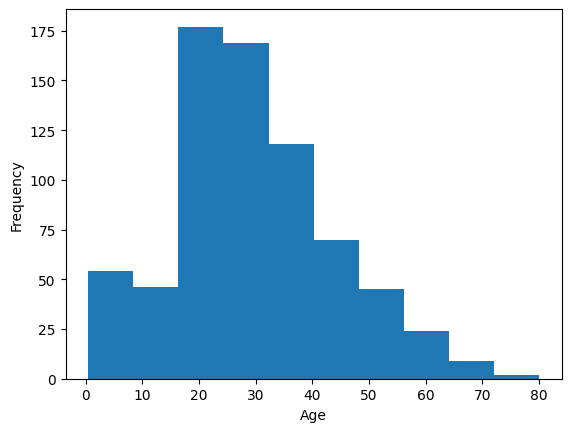

In [97]:
import matplotlib.pyplot as plt
plt.hist(df["Age"])
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.plot()

<!-- JPN -->
　最大が0才から80才程度なので、どうやら変な値は入っていないようだ。

<!-- ENG -->
　The maximum is about in between 0 and 80 years old, so it would be expected there are no strange values in there.


<!-- JPN -->
　次に、全ての説明変数について、値の欠損が存在しないか確認する。以下のコードで実行する `describe()` メソッドは、各数値型の特徴量の記述統計量を出力する。

<!-- ENG -->
　Next, for all explanatory variables, check for the presence of missing values. The `describe()` method executed in the following code outputs the descriptive statistics of feature values of each numeric type.

In [98]:
print(df.describe())

           Pclass         Age        Fare    Survived      IsMale
count  891.000000  714.000000  891.000000  891.000000  891.000000
mean     2.308642   29.699118   32.204208    0.383838    0.647587
std      0.836071   14.526497   49.693429    0.486592    0.477990
min      1.000000    0.420000    0.000000    0.000000    0.000000
25%      2.000000   20.125000    7.910400    0.000000    0.000000
50%      3.000000   28.000000   14.454200    0.000000    1.000000
75%      3.000000   38.000000   31.000000    1.000000    1.000000
max      3.000000   80.000000  512.329200    1.000000    1.000000


<!-- JPN -->
　ここで注目すべきは、**`Age`の`count`が他の件数と異なり、714となっている**。 `describe()` メソッドでは、**欠損していないデータの数**が `count` に表示されるため、年齢情報には欠損値が存在していることを示唆している。

　それでは、実際に欠損値を探してみる。値が欠損しているかどうかの判定は`isna()`で行うことができる（IS Not A number の略である）。

<!-- ENG -->
　We should pay attention to that **the `count` for the `Age` is 714**, unlike the other counts in the `describe()` method, **the number of data with missing values** is displayed in the `count`, which implies that there are missing values in the age information.

　Now, let's actually try to find the missing values. The determination of whether there is a missing value can be confirmed with `isna()` (which stands for IS Not A number).

In [99]:
print(df["Age"].isna())

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888     True
889    False
890    False
Name: Age, Length: 891, dtype: bool


<!-- JPN -->
　しばしば`True`が表示されており、値の欠損が確かに存在していることがわかる。年齢が欠損しているデータを確認してみよう。

<!-- ENG -->
　Quite often `True` is displayed, indicating that a missing value is indeed present. Let's check the data that has missing values in the Age information.

In [100]:
print(df[df["Age"].isna()]) # Extract all data that has missing values in the Age information

     Pclass     Sex  Age     Fare  Survived  IsMale
5         3    male  NaN   8.4583         0       1
17        2    male  NaN  13.0000         1       1
19        3  female  NaN   7.2250         1       0
26        3    male  NaN   7.2250         0       1
28        3  female  NaN   7.8792         1       0
..      ...     ...  ...      ...       ...     ...
859       3    male  NaN   7.2292         0       1
863       3  female  NaN  69.5500         0       0
868       3    male  NaN   9.5000         0       1
878       3    male  NaN   7.8958         0       1
888       3  female  NaN  23.4500         0       0

[177 rows x 6 columns]


<!-- JPN -->
　多くの学習手法は、全てのデータが埋まりきっていることを前提としているため、欠損値を含むデータを除外する、あるいはこれらの欠損値をなんらかの値で補填する必要がある。


<!-- ENG -->
　Many machine learning methods assume that all the data is filled in, so it is necessary to exclude data with missing values, or to compensate for these data items with some values.


<!-- JPN -->

　ここでは、（極めて雑な処理なのだが）平均値で年齢を埋めてしまうことにする。欠損値を埋める、という操作は`fillna()`という関数で行うことができる。

<!-- ENG -->

　Here, we will fill in the age with the average (which is an extremely rough process). The operation of filling in missing values can be performed with the function `fillna()`.

In [101]:
ave_age = df["Age"].mean()
df["Age"] = df["Age"].fillna(ave_age)

In [102]:
print(df.describe())

           Pclass         Age        Fare    Survived      IsMale
count  891.000000  891.000000  891.000000  891.000000  891.000000
mean     2.308642   29.699118   32.204208    0.383838    0.647587
std      0.836071   13.002015   49.693429    0.486592    0.477990
min      1.000000    0.420000    0.000000    0.000000    0.000000
25%      2.000000   22.000000    7.910400    0.000000    0.000000
50%      3.000000   29.699118   14.454200    0.000000    1.000000
75%      3.000000   35.000000   31.000000    1.000000    1.000000
max      3.000000   80.000000  512.329200    1.000000    1.000000


<!-- JPN -->
　これでデータクレンジングが完了した。

　最後に、説明変数 `X` と目的変数 `y` に分割した上で、`X` と `y` を**訓練データ (training data)** と**テストデータ (test data)** に分割する。これは、 scikit-learn の `train_test_split()` 関数が便利である。

<!-- ENG -->
　The data cleansing is now complete.

　Finally, after splitting the data into explanatory variable `X` and class label `y`, `X` and `y` are split into **training data** and **test data**. For this, scikit-learn's `train_test_split()` function is useful.

In [103]:
X = df[["Pclass", "Age", "Fare", "IsMale"]]
y = df["Survived"]

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=0)
# Set test_size=0.2 to make 20% of all data as test data

<!-- JPN -->
　これにより、データは下図のように分割された。

<!-- ENG -->
　This resulted in the data being split as shown.

<img src="https://i.imgur.com/Y1DW99k.png" alt="Figure 1" width="50%">

<!-- JPN -->
## 2 | 決定木を用いた分類

<!-- ENG -->
## 2 | Classification using decision trees

<!-- JPN -->
　決定木 (decision tree) とは、下図のように、**目的変数をよりキレイに分類できる説明変数と閾値で分岐させ続ける**ことで分類を行うモデルである。一般的には3つ以上にいきなり分岐させることも決定木の範疇だが、これから利用する `scikit-learn` の決定木は2つに分岐させることにのみ対応している。

<!-- ENG -->
　A decision tree is a model that performs classification by **continuously branching the class label with explanatory variables and thresholds that can classify it more neatly**, as shown in a figure. In general, although three or more branches are also within the scope of decision trees, the scikit-learn decision tree we are going to use supports only two branches.

<img src="https://i.imgur.com/05tNGSr.png" alt="Figure 2" width="50%">

<!-- JPN -->
**決定木の例（Wikipedia 「決定木」 より抜粋）**

<!-- ENG -->
**Decision tree example (extracted from Wikipedia "Decision tree")**

<!-- JPN -->
### 2.1 | `scikit-learn` を利用した決定木の構築と予測


<!-- ENG -->
### 2.1 | Building and predicting decision trees using `scikit-learn`


<!-- JPN -->
　決定木は `DecisionTreeClassifier()` という名前で用意されているので、これを用いる。

<!-- ENG -->
　The decision tree is provided with the name `DecisionTreeClassifier()`, which we will use.

In [105]:
from sklearn.tree import DecisionTreeClassifier

In [106]:
model_full = DecisionTreeClassifier(random_state=0) # Fix random numbers for reproducibility

<!-- JPN -->
　上記のコードは見た目上は「`DecisionTreeClassifier()` という関数に `random_state=0` という引数を渡した返り値を `model_full` に格納した」ようになっているが、実際には**決定木を構築するための（からっぽな）モデルの骨組み（インスタンス）を準備して、`model_full`という名前を付けた**と考えてほしい。


<!-- ENG -->
　The above code looks like "The return value of the function `DecisionTreeClassifier()` with the argument `random_state=0` is stored in `model_full`", however, the real meaning of the code is to **prepare the skeleton of a (empty) model (instance) for building a decision tree, and giving it the name `model_full`**.


<!-- JPN -->
　これに対して、`model_full.fit()` を行うことで、実際に決定木モデルを構築することができる。ジニ不純度 (gini impurity) を分割の基準とした決定木の構築がデフォルト値となっている。

<!-- ENG -->
　Then, by performing `model_full.fit()`, we can actually build a decision tree model. Constructing a decision tree using the Gini impurity is the default option in scikit-learn.

In [107]:
model_full.fit(X_train, y_train) # Give the explanatory variables and class labels of the training data as arguments.

# Note: The following code is wrong
# trained = model_full.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

<!-- JPN -->
　これだけで決定木の構築が完了した。 **`model_full` 自体が書き換えられるので、代入を行う必要がない**ことに注意せよ。

　この学習済みモデルに対して、 `model_full.predict()` を行うことで訓練データの予測を行ってみる。

<!-- ENG -->
　This completes the construction of the decision tree. Note that **the `model_full` itself is updated, so there is no need to carry out substitution**.

　For this trained model, we will try to predict the training data by using `model_full.predict()`.

In [108]:
pred_y_train = model_full.predict(X_train) # Try predicting the training data
print(pred_y_train) # Display the prediction result

[0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0
 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1
 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0
 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0
 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0
 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1
 0 0 0 0 1 0 0 1 0 0 0 0 

<!-- JPN -->
　出力結果は0と1の羅列だが、これは死亡=0、生存=1という意味で、今回説明変数として与えた4種類の情報から予測を行った結果を示している。

　次に、実際の生存結果 `y_train` と比較を行い、予測があっていたら `True` 、間違っていたら `False` とするような配列を作成しよう。

<!-- ENG -->
　The output result is a series of 0s and 1s, meaning that death=0 and survival=1, indicating that the result of prediction is based on the four types of information given as explanatory variables.

　Next, let's create an array where elements will be `True` if the prediction is correct and `False` if the prediction is wrong by comparing to the actual survival result `y_train`.

In [109]:
# Compare whether the results match for each element of the NumPy array
prediction_result = (pred_y_train == y_train)
print(prediction_result)

140    True
439    True
817    True
378    True
491    True
       ... 
835    True
192    True
629    True
559    True
684    True
Name: Survived, Length: 712, dtype: bool


<!-- JPN -->
　非常に `True` が多く、正しく予測できている確率が高そうだ。最後に、正解率（＝ `True` の確率）を計算する。少しトリッキーだが、`True`/`False` の配列の平均値を計算することで、正解率を求めることができる。

<!-- ENG -->
　There are a lot of instances where `True` is the dominant case, and the probability of predicting correctly seems to be high. Finally, calculate the accuracy (= probability of `True`). It is a little tricky, but by calculating the average value of the `True`/`False` array, you can get the accuracy.

In [110]:
# Since True=1 and False=0 in np.mean,
# the true rate can be obtained by simply calculating the mean.
accuracy = np.mean(prediction_result)
print(accuracy)

0.9789325842696629


<!-- JPN -->
　さて、決定木モデルは、学習済みモデルを画像で出力することができる。
graphvizというツールの形式で出力されるため、`dot`というコマンドでPNG画像に変換する。

<!-- ENG -->
　Now, the decision tree model can output the trained model as an image.
Because the output is in the form of a tool called graphviz, convert it to a PNG image using the `dot` command.

In [111]:
from sklearn import tree
tree.export_graphviz(model_full, out_file = "tree_full.dot",
                     feature_names = X.columns,               # Display the feature value names
                     impurity = False,                        # Simplify the display
                     class_names = ["Died", "Survive"])       # Display the prediction results

In [112]:
# Use graphviz to convert to PNG or other formats.
# The following command is not a Python mechanism, but a Google Colaboratory mechanism
!dot -Tpng tree_full.dot -o tree_full.png # This will create an image file
# Download the file from the left pane

<!-- JPN -->
　ファイルをダウンロードして、閲覧してみよう。（とんでもない）図が作成されているはずだ。
このように、一番上の部分から左右に2分割され続ける構造を「二分木」と言う。最初にも述べたが、`scikit-learn` の決定木は必ず二分木となる。

<!-- ENG -->
　Download the file and have a look. An (outrageous) diagram should have been created.
This structure, which is divided into two continuous parts from the top part to the left and right, is called a "binary tree.” As mentioned at the beginning, decision trees in `scikit-learn` are always binary trees.

![Figure 3](https://i.imgur.com/eBhPZCO.png)


---

<!-- JPN -->
##### 課題 1
　先ほどは訓練データ`X_train`を使って、`y_train`を予測した。

　同様にテストデータ`X_test`の予測を行い、`y_test`との比較を行うことで、予測正解率を変数 `accuracy` に保管せよ。

<!-- ENG -->
##### Exercise 1
　We used the training data `X_train` to predict `y_train` earlier.

　Similarly, by predicting the test data `X_test` and comparing it with `y_test`, assign prediction accuracy to a variable `accuracy`.

In [113]:
# CODE CELL FOR YOUR ANSWER
pred_y_test = model_full.predict(X_test)
print(pred_y_test)
prediction_result = (pred_y_test == y_test)
accuracy = np.mean(prediction_result)
print(accuracy)

[0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0
 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0
 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0
 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1]
0.7988826815642458


--------

<!-- JPN -->
### 2.2 | よりシンプルな決定木の構築

　2.1節で作成した決定木は非常に複雑であった。今度は、決定木の深さ（縦方向の大きさ）を制限することで、もっと簡単な決定木を作ってみよう。

<!-- ENG -->
### 2.2 | Building a simpler decision tree

　The decision tree created in section 2.1 was very complex. Now let's try to make a simpler decision tree by restricting the depth (vertical size) of the decision tree.

<!-- JPN -->
　決定木の深さはモデルの引数で制限することが可能である。

<!-- ENG -->
　The depth of the decision tree can be limited by the argument of the model.

In [114]:
model_simple = DecisionTreeClassifier(max_depth=3, random_state=0) # Limit the maximum depth to 3
model_simple.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

<!-- JPN -->
　`model_full`の時と同様に、木構造を画像にしてみよう。

<!-- ENG -->
　As with `model_full`, let's turn the tree structure into an image.

In [116]:
from sklearn import tree
tree.export_graphviz(model_simple, out_file = "tree_simple.dot",
                     feature_names = X.columns,
                     impurity = False,
                     class_names = ["Died", "Survive"])

In [117]:
# Use graphviz to convert to PNG, etc. graphviz is already included in Google Colab.
!dot -Tpng tree_simple.dot -o tree_simple.png # This will create an image file

<!-- JPN -->
　`tree_simple.png` も画像ファイルを開いて目視してみよう。
こちらは木の深さ（一番上から一番したまでの経路の長さ）が3に制限されているので、比較的わかりやすい図になっている。

<!-- ENG -->
　Let's also open the `tree_simple.png` and have a look at it.
This diagram is relatively easy to understand because the depth of the tree (the length of the path from the top to the bottom) is limited to 3.

![Figure 4](https://i.imgur.com/mcrnEs8.png)

---

<!-- JPN -->
##### 課題 2

　深さを制限した決定木を言葉で表現してみよう。例えば、一番下の段、右から4番目は「男性で、年齢が14才以下で、1等室か2等室の乗客は11人中11人生存している」という意味である。

　**一番下の段、左から3番目**について、「～～で、～～～で、～～～～の乗客は92人中57人生存している」と文章で記述せよ。

<!-- ENG -->
##### Exercise 2

　Let's try to express the depth-limited decision tree in words. For example, the bottom row, fourth from the right, means "11 out of 11 passengers who are male, under 14 years of age, and in first or second class are alive."

　**For the bottom row, third from the left**, write the sentence, "57 out of 92  passengers who  \_\_\_\_\_\_\_\_\_\_\_, \_\_\_\_\_\_\_\_\_\_\_\_, and \_\_\_\_\_\_\_\_\_\__ are alive."

57 out of 92  passengers who are female, paied under 23.35\_, and in first or second class are alive.

---

<!-- JPN -->
##### 課題 3

　以下のコードの`__xxxxx__` 、`__yyyyy__` 、`__zzzzz__` を埋めて、確かに条件に該当する人が92人いることを確認せよ。

<!-- ENG -->
##### Exercise 3

　Fill in `__xxxxx__`, `__yyyyy__`, and `__zzzzzzz__` for the following code to verify that there are indeed 92 people who meet the criteria.

In [133]:
# CODE CELL FOR YOUR ANSWER

# select rows who satisfy the first condition
selection1 = X[X['IsMale'] <= 0.5]
# select rows who satisfy the second condition
selection2 = selection1[selection1['Pclass'] <= 2.5]
# select rows who satisfy the third condition
selection3 = selection2[selection2['Fare'] <= 23.35]

print(len(selection3))

42


---

<!-- JPN -->
##### 課題 4

　`model_simple` について、訓練データ `X_train` 、`y_train` に対して予測を行った時の正解率を計算し、 `training_accuracy_for_model_simple` に保管せよ。

　同様にテストデータ `X_test` 、`y_test` に対する予測の正解率を計算し、 `test_accuracy_for_model_simple` に保管せよ。

<!-- ENG -->
##### Exercise 4

　For `model_simple`, calculate the prediction accuracy for the training data `X_train` and `y_train`, and assign the prediction accuracy into `training_accuracy_for_model_simple`.

　In the same way, calculate the prediction accuracy for the test data `X_test` and `y_test`, and assign the prediction accuracy into `test_accuracy_for_model_simple`.

<!-- JPN -->
　なお、計算を行った後に、 `model_full` と `model_simple` について、「訓練データの予測精度」「テストデータの予測精度」について比較をしておくこと。（提出には含めない）

<!-- ENG -->
　Additionally, compare the prediction accuracies of training data between `model_full` and `model_simple`. In the same way, compare the prediction accuracies of test data. (no submission required)

In [119]:
# CODE CELL FOR YOUR ANSWER
from sklearn.metrics import accuracy_score

pred_y_train_s = model_simple.predict(X_train)
prediction_result_trains = (pred_y_train_s == y_train)
training_accuracy_for_model_simple = np.mean(prediction_result_trains)

pred_y_test_s = model_simple.predict(X_test)
prediction_result_tests = (pred_y_test_s == y_test)
test_accuracy_for_model_simple = np.mean(prediction_result_tests)

print(training_accuracy_for_model_simple)
print(test_accuracy_for_model_simple)

0.827247191011236
0.8100558659217877


---

<!-- JPN -->
### 2.3 | 交差検証法 (cross validation) を用いた2つのモデルの評価 (model assessment)


<!-- ENG -->
### 2.3 | Assessment of two models using cross validation


<!-- JPN -->
　課題 4は、「訓練データに対する正解率」と「テストデータに対する正解率」それぞれを比較する問題であったが、どちらの方が重要だろうか。

　母集団 (population) に対する平均的な予測精度（これを**汎化性能 (generalization performance)** と呼ぶ）が**高い方が利用価値の高い**モデルであるはずであり、**テストデータに対する性能で汎化性能を推定**している。
つまり、**「テストデータに対する正解率」でモデルを比較すべきである**。

　さらに、データのtraining/test分割を複数通り試すことで、**汎化性能を高精度に推定**することができる。その際に最も広く用いられるのが **$k$-分割交差検証法（$k$-fold cross validation, $k$-fold CV）**である。$k$-分割交差検証法では、データを $k$ 個に分割（図の例では $k=4$ ）して、 $k-1$ 個のグループを訓練データに、1個のグループをテストデータにした時の汎化性能を $k$ 回求め、その平均値（と標準偏差）でモデルの性能を評価する。また、$k$ がデータ数と同じ場合（つまり、一つのデータをテスト
データにする場合）を特に**一個抜き交差検証法（leave-one-out cross validation, LOOCV）**という。

<!-- ENG -->
　Exercise 4 is a question about comparing “the accuracy to the training data” and “the accuracy to the test data,” but which is more important?

　A model with **higher average prediction accuracy for a population (called generalization performance) should be more valuable**, so **we are estimating generalization performance by its performance on test data**.
In other words, **models should be compared on the basis of "accuracy to test data".**

　Furthermore, by trying multiple ways of splitting the training/test data, **the generalization performance can be estimated with high accuracy**. The most widely used method for this purpose is **$k$-fold cross validation ($k$-fold CV)**. In the $k$-fold cross validation, the data set is divided into $k$ groups ($k=4$ in the example in the figure), and the generalization performance is obtained $k$ times when $k-1$ groups are used as training data and 1 group as test data, and the performance of the model is evaluated by the mean (and standard deviation) of the results. Also, when $k$ is the same as the number of data (i.e., when one data item is used as test data), it is called **leave-one-out cross validation (LOOCV)**.


<img src="https://i.imgur.com/AUMBdH0.png" alt="Figure 5" width="50%">

<!-- JPN -->
**交差検証法 (cross validation) のデータ分割イメージ** | 4-fold 交差検証法を図示している。

<!-- ENG -->
**Cross validation data splitting illustration** | It illustrates the 4-fold cross validation.

<!-- JPN -->
　scikit-learnでは、交差検証法も `cross_val_score()` を用いることで簡単に実行することができる。関数の中でデータ分割を行うため、**`cross_val_score()` には全データを与える**ことに注意しよう。

<!-- ENG -->
　In scikit-learn, cross validation can also be easily performed by using `cross_val_score()`. Note that **all the data is given to `cross_val_score()`** because data division is performed in the function.

In [120]:
from sklearn.model_selection import cross_val_score
import numpy as np

model_full = DecisionTreeClassifier(random_state=0)
full_cv_scores = cross_val_score(model_full, X, y, cv=4)
print(np.mean(full_cv_scores), "+-", np.std(full_cv_scores))

0.7587110653254151 +- 0.020491613730365087


In [121]:
model_simple = DecisionTreeClassifier(max_depth=3, random_state=0)
simple_cv_scores = cross_val_score(model_simple, X, y, cv=4)
print(np.mean(simple_cv_scores), "+-", np.std(simple_cv_scores))

0.8137043994667312 +- 0.017097021687140168


<!-- JPN -->
　この結果から、木の深さを制限した決定木 `model_simple`の方が汎化性能が高いことがわかる（**補足資料 ※2**）。

<!-- ENG -->
　This result shows that the decision tree `model_simple` with restricted tree depth has a better generalization performance (**Supplementary Material S2**).

<!-- JPN -->
## 3 | モデル選択 (model selection)

<!-- ENG -->
## 3 | Model selection

<!-- JPN -->
　第2章で、木の深さを制限した方が汎化性能が高いことが分かったが、ここでは**汎化性能を最大化する最適な決定木の最大深さを探してみる**。このように、複数の学習モデルから最良のモデルを選ぶことを**モデル選択 (model selection)** と呼ぶ。

<!-- ENG -->
　In section 2, we found that the generalization performance is better when the depth of the tree is restricted, and here **we try to find the maximum depth of the optimal decision tree that maximizes the generalization performance**. This process of selecting the best model from multiple training models is called **model selection**.

<!-- JPN -->
### 3.1 | training/validation/test 分割

<!-- ENG -->
### 3.1 | training/validation/test splitting

<!-- JPN -->
　モデル選択（例：決定木における「木の最大深」の最適化）においては、汎化性能を正しく推定するために訓練データ (training data) 、**検証データ (validation data)** 、テストデータ (test data) の3データに分割した上で、以下の手順を踏む（**補足資料 ※3**）。

* **モデル選択 (model selection)** ：検証データ (validation data) を最もよく予測できるモデルを選ぶ
* **モデルの評価 (model assessment)** ：最良モデルを使ってテストデータ (test data) を予測し、汎化性能を推定する

<!-- ENG -->
In selecting the model (e.g., optimizing the "maximum tree depth" in decision trees), the following steps are taken after splitting the data into three, training data, **validation data**, and test data, in order to correctly estimate the generalization performance (**Supplementary Material S3**).

* **Model selection**: Choose the model that best predicts the validation data
* **Model assessment**: Predict test data using the best model and estimate generalization performance

<!-- JPN -->
### 3.2 | 交差検証法を用いたモデルの選択

<!-- ENG -->
### 3.2 | Model selection using cross validation

<!-- JPN -->
　それでは、2.3節でも用いた交差検証法を用いて、決定木の深さの最大値はいくつにするのが最も良さそうか、確かめてみよう（このように、学習を行う前に指定しなければならない変数のことを**ハイパーパラメータ**と呼ぶ）。

　この場合、**テストデータはあらかじめ除外した上で、訓練データと検証データの分割を交差検証法によって複数回試す**のが良い。

<!-- ENG -->
　Let's use cross validation that we have used in section 2.3 to see what the maximum value of the depth of the decision tree should be (the variables that must be specified before training are called **hyperparameters**).

　In this case, it is better to **exclude the test data beforehand and try multiple times to split the training and validation data using cross validation**.

<img src="https://i.imgur.com/2i5U90o.png" alt="Figure 6" width="50%">

<!-- JPN -->
**モデル選択時の交差検証法 (cross validation) のデータ分割イメージ** | 20%をテストデータにしたうえで、4-fold 交差検証法を行った場合を図示している。

<!-- ENG -->
**Illustration of data splitting for cross validation when selecting the model** | The figure shows the case where 4-fold cross validation is performed after making 20% of all data set as test data.

<!-- JPN -->
　このようなデータ分割を実現するには、まず`train_test_split()` を行い、`X_train`, `y_train`, `X_test`, `y_test`に分割した上で、`X_train`と`y_train`をつかって交差検証法を行えばよい。

　ハイパーパラメータの探索時には交差検証法は極めてよく利用されるため、scikit-learnでは `GridSearchCV()` 関数が用意されている。以下では、これを用いて最適なハイパーパラメータを探索している。

<!-- ENG -->
　To achieve the data split shown in the figure, we first perform `train_test_split()` to split the data into `X_train`, `y_train`, `X_test`, and `y_test`, and then use `X_train` and `y_train` to perform cross validation.

　Since cross validation is very often used when searching for hyperparameters, it is provided as the `GridSearchCV()` function in scikit-learn. In the following, we use this to search for the optimal hyperparameters.

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
# Set test_size=0.2 to make 20% of all data as test data

In [123]:
# Array with one dictionary type in it
param_grid = [
  {
    "max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
  }
]
template_model = DecisionTreeClassifier(random_state=0)          # Prepare the decision tree model framework
grid_search_dt = GridSearchCV(template_model, param_grid, cv=4)  # Give an instruction to determine the optimal model by performing 4-fold CV.
grid_search_dt.fit(X_train, y_train)                             # Determine the optimal model by giving the actual data and performing an internal training/validation split
print(grid_search_dt.best_params_)                               # Confirm the optimal hyperparameters
print(grid_search_dt.best_score_)                                # Display the prediction accuracy of the validation set on the optimal hyperparameters.

{'max_depth': 8}
0.8061797752808988


<!-- JPN -->
　これで titanic データに対する正解率が最大になる木の深さを推定することができた。新しいデータを予測する時には、このモデルを使うと良さそうだ。

　最後に、このモデルでテストデータを予測することで、汎化性能を推定しよう。


<!-- ENG -->
　This will allow us to predict the maximum tree depth where the accuracy for the titanic data is at the highest. This model seems to be a good one to use when predicting new data.

　Finally, let's estimate the generalization performance by predicting the test data with this model.


In [124]:
pred_y_test = grid_search_dt.predict(X_test)
prediction_result = (y_test == pred_y_test)
accuracy = np.mean(prediction_result)
print(accuracy)

0.7988826815642458


<!-- JPN -->
　以上で、交差検証法を用いたモデル選択を行い、最良モデルの汎化性能を推定することができた（**補足資料 ※4**）。


<!-- ENG -->
　In the above, we were able to perform model selection using cross validation and estimate the generalization performance of the best model (**Supplementary Material S4**).


<!-- JPN -->
　今回の授業では、2種類の交差検証法 cross validation の説明を行ったが、どう使い分ければよいか理解できただろうか。**自分が作ることのできる「学習器とハイパーパラメータの組み合わせ」が複数あるなら、訓練データと検証データを使って自分の最強モデルを決め**、**他人の手法と比較するときはテストデータを使って比較する**と考えておくと良い。

<!-- ENG -->
　In this lesson, we explained the two types of cross validations, but I hope you have understood how to use them differently. **When there are multiple "combinations of learners and hyperparameters" that you can create, you can use training data and validation data to determine your strongest model**, **and when comparing with other people's methods you can use test data**.

---

<!-- JPN -->

##### 課題 5

　講義資料では、決定木の最大深さのみをいろいろ変化させて評価したが、これに加えて、`min_samples_leaf`という値も同時に最適化したい。

　**`min_samples_leaf`とはどういうパラメータか調べ、簡潔に答えよ**。

<!-- ENG -->
##### Exercise 5

　In the lecture material, we evaluated the decision tree by varying only the maximum depth of the decision tree, but we also want to optimize the value of `min_samples_leaf` at the same time.

　**Find out what kind of parameter `min_samples_leaf` is, and provide a brief answer.**

The min_samples_leaf parameter in decision tree algorithms specifies the minimum number of samples (data points or instances) that should be present in a leaf node. A leaf node is a node in the decision tree where no further splits are made, and it represents a final decision or class label.

-----

<!-- JPN -->

##### 課題 6

　次に、`GridSearchCV()` を用いて、`min_samples_leaf`も含め、パラメータ探索を行い、最良のモデルの`max_depth`と`min_samples_leaf`の値、およびテストデータ予測時の正解率 `test_accuracy` を答えよ。ハイパーパラメータの探索範囲は以下の通りとして、$20 \times 10 = 200$ 通りのハイパーパラメータから最適なパラメータを選択する。

|ハイパーパラメータ名 | 値の範囲 |
|---------------------|----------|
|`max_depth`          |`[1,2,3, ... ,19,20]`|
|`min_samples_leaf`   |`[1,2,3, ... ,9,10]`|

なお、実行結果の再現性を担保するため、`random_state` は消したり書き換えたりしないようにせよ。

------

<!-- ENG -->
##### Exercise 6

Next, use `GridSearchCV()` to search for $20 \times 10 = 200$ parameters including `min_samples_leaf`, and answer the values of `max_depth` and `min_samples_leaf` for the best model, and the accuracy when predicting the test data `test_accuracy`.

|hyper parameter| value range |
|---------------------|----------|
|`max_depth`          |`[1,2,3, ... ,19,20]`|
|`min_samples_leaf`   |`[1,2,3, ... ,9,10]`|

To ensure reproducibility of the execution results, do not remove nor modify `random_state` written in it.

In [142]:
# CODE CELL FOR YOUR ANSWER

# Generate data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# Set search parameters as a variable `param_grid`
param_grid = [
    {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    }
]

# Determine the best model by performing 4-fold CV
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=4)
grid_search_dt.fit(X_train, y_train)
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)

max_depth = grid_search_dt.best_params_['max_depth']
min_samples_leaf = grid_search_dt.best_params_["min_samples_leaf"]
print("max_depth:",max_depth,"min_samples_leaf:",min_samples_leaf)

# Evaluation using test data
pred_y_test = grid_search_dt.predict(X_test)
prediction_result = (y_test == pred_y_test)
test_accuracy = np.mean(prediction_result)
print("test_accuracy:",test_accuracy)

{'max_depth': 8, 'min_samples_leaf': 5}
0.8117977528089887
max_depth: 8 min_samples_leaf: 5
test_accuracy: 0.8212290502793296


<!-- JPN -->

##### 課題 7（実践、提出不要）

<!-- ENG -->

##### Exercise 7 (Practical, not required to submit)

<!-- JPN -->

決定木モデルを用いて [Heart Disease Dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset?resource=download) の患者の心臓病の有無を予測してみよう。

<!-- ENG -->

Let's predict whether a patient has heart disease or not ([Heart Disease Dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset?resource=download)) using a decision tree model.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("heart.csv")
X_train, X_test, y_train, y_test = train_test_split(data.drop("target", axis=1), data["target"], test_size=0.3, random_state=0)

<!-- JPN -->

　(1) まず、 `max_depth=4`, `min_sample_leaf=3`、それ以外のパラメータ1つを自分で設定して、決定木モデルを構築してテストデータ予測時の正解率を算出せよ。この際、テストデータに対する正解率は **百分率で小数点以下1桁** 程度にすると良い。

<!-- ENG -->

　(1) First, Set `max_depth=4`, `min_sample_leaf=3` and one other parameter by yourself, build a decision tree model, predict test data, and calculate the percentage of accuracy to the test data. In this case, the percentage should be about **one decimal place in percentage**.

<!-- JPN -->
　(2) 続いて、`max_depth`, `min_sample_leaf` および (1) で選択したハイパーパラメータについてグリッドサーチを行え。グリッドサーチを行う範囲は自分で指定して良いが、最適なハイパーパラメータがその範囲の上端・下端にならないように、適宜ハイパーパラメータの範囲を調整すること。また、ハイパーパラメータごとの正解率をヒートマップ等で表示することで、ハイパーパラメータと正解率の関係性について論じよ。

<!-- ENG -->
　(2) Next, perform a grid search for `max_depth`, `min_sample_leaf`, and the hyperparameter selected in (1). You may specify the range of the grid search, but adjust the range of hyperparameters accordingly so that the most appropriate hyperparameters are not at the top or bottom of the range. Also, discuss the relatioship between the hyperparameters and the percentage of the accuracy using heatmaps etc.

<!-- JPN -->

なお、データセットのカラムに関する説明[<sup>1</sup>](#cap1_ja)は以下の通りである。

|カラム名|説明|
|---|---|
|age|患者の年齢|
|sex|患者の性別|
|cp|胸の痛みの種類 (4 種類)|
|trestbps|安静時血圧|
|chol|血清コレストロール(mg/dl)|
|fbs|空腹時血糖値 (120 mg/dlより大きい場合は1, そうでない場合は0)|
|restecg|安静時の心電図結果 (0,1,2のいずれか)|
|thalach|最大心拍数|
|exang|運動誘発狭心症の有無(2値)|
|oldpeak|安静時に対して運動により誘発されるST[<sup>2</sup>](#cap2_ja)低下|
|slope|運動時STピークセグメントの傾き|
|ca|蛍光透視法で着色した主要血管の数(0, 1, 2, 3)|
|thal|0 = normal; 1 = fixed defect; 2 = reversable defect|
|target|患者の心臓病の有無 (1 = 有, 0 = 無)|

<span id="cap1_ja">1: [Kaggle Dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset?resource=download)から引用</span>  
<span id="cap2_ja">2: 心電図のS波の終わりからT波の始まりまでの部分。 心筋梗塞や心筋炎などでSTの異常な上昇がみられ、心臓からの血液の流れが悪い場合などでSTの異常な低下がみられる。
(参考: [日本心臓財団 心臓病用語辞典](https://www.jhf.or.jp/check/term/word_a/st/)、[日本人間ドック学会 心電図](https://www.ningen-dock.jp/public/inspection/electrocardiogram))</span>

<!-- ENG -->

The explanation of the columns of the dataset is as follows.[<sup>1</sup>](#cap1_en)

|column|description|
|---|---|
|age|age|
|sex|sex|
|cp|chest pain type (4 values)|
|trestbps|resting blood pressure|
|chol|serum cholestoral in mg/dl|
|fbs|fasting blood sugar > 120 mg/dl|
|restecg|resting electrocardiographic results (values 0,1,2)|
|thalach|maximum heart rate achieved|
|exang|exercise induced angina|
|oldpeak|ST depression induced by exercise relative to rest|
|slope|the slope of the peak exercise ST segment[<sup>2</sup>](#cap2_en)|
|ca|number of major vessels (0-3) colored by flourosopy|
|thal|0 = normal; 1 = fixed defect; 2 = reversable defect|
|target|patient's presence of heart disease (1 = yes, 0 = no)|

<span id="cap1_en">1: quoted from [Kaggle Dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset?resource=download)</span>  
<span id="cap2_en">2: The ST segment on an electrocardiogram (ECG) normally represents an electrically neutral area of the complex between ventricular depolarization (QRS complex) and repolarization (T wave). However, it can take on various waveform morphologies that may indicate benign or clinically significant injury or insult to the myocardium. Understanding the differential diagnosis for variations in the ST segment is critical for clinical management as it can influence treatment. This article summarizes ST segment, including how it is defined, measured, and how it varies. This article also examines and summarizes ST-segment morphologies unique to various conditions that present with ST elevation or depression.
(quoted from [National Center for Biotechnology Information, National Library of Medicine](https://www.ncbi.nlm.nih.gov/books/NBK459364/))</span>

-------

<!-- JPN -->
## 補足資料

<!-- ENG -->
## Supplementary Material

<!-- JPN -->
### ※1 データクレンジングの重要性

　データサイエンスを行う場合、第2回の講義で利用したirisのように全てのデータが完全に埋まっていることはあまり多くなく、記載されている情報すら誤りが含まれている。

　例えば、欠損は以下のようなときに発生する。
* 必須登録項目ではない
  * 例：SNSにおける生年月日
* 選択肢に「不明」が含まれる
  * 例：性別（LGBT等への配慮）

　また、情報の誤りは以下のケースが考えられる。
* 意図的な虚偽申告
  * 例：1人暮らし女性などの通販サイトの「男性」としての登録（防犯上の理由）
* 初期設定が原因である虚偽申告
  * 都道府県（初期設定が北海道で、変更せずそのまま登録）
* 複数人が同一アカウントを利用している
  * 母親のアカウントで家族全員分の通販を処理
  
　このため、ユーザが自己申告する情報を鵜呑みにせず、購入履歴などから情報を推定することも重要になったりする。

　また、機械的なものであっても、センサーの不具合や故障によって、欠測や誤った計測値の出力は発生するため、こちらもやはり前後のデータから誤りが発生していないか判定することが必要になる。

　これらのデータの「汚れ」をキレイにすることは**極めて重要**であり、かつ極めて地味な作業でもある。



<!-- ENG -->
### S1 Importance of data cleansing

　In the case of data science, it is not common that all data is completely filled in like iris which was used in the second lecture, and even the information listed contains errors.

　For example, missing values occur in the following cases.
* Not a required registration field
  * Example: Date of birth in social media platforms
* "Unknown" is included as an option
  * Example: Gender (consideration for LGBT, etc.)

　In addition, the following cases of information errors are possible.
* Intentional misrepresentation
  * Example: Registration as "Male" on a mail order website for women living alone, etc. (for security reasons)
* False declaration caused by default settings
  * Prefecture (default setting is Hokkaido, registration applied without changing)
* Multiple people are using the same account
  * The parent account handles mail orders for the whole family
  
　For this reason, it is important not to rely solely on the information self-reported by the user, but to estimate information from the purchase history.

　Even if it is mechanical, missing or incorrect measurements can be output due to sensor failure or malfunction, so it is still necessary to determine whether errors have occurred from the previous or subsequent data.

　Cleaning up the "dirty" data on these types of data is both **extremely important** but a very tiresome task.



<!-- JPN -->
### ※2 model_simpleはmodel_fullよりも「有意」に汎化性能が高いのか？

　model_simpleの方がmodel_fullよりも予測精度の平均が高いことが分かったが、これは偶然なのだろうか、それとも有意に差があるのだろうか。ウィルコクソンの符号順位検定を行うことで、model_simpleがmodel_fullに勝っているかどうか統計的に評価してみよう。


　ここでは、帰無仮説を「model_simpleの予測精度とmodel_fullの予測精度に差がない」、有意水準を $\alpha=0.05$ とする。
ウィルコクソンの符号順位検定は、SciPyというパッケージを利用することで行うことが出来る。

<!-- ENG -->
### S2 Does model_simple have "significantly" better generalization performance than model_full?

　We have found that model_simple has a higher average prediction accuracy than model_full, but is this a coincidence or is there a significant difference? Let's statistically evaluate whether model_simple outperforms model_full by performing a Wilcoxon signed-rank test.


　Here, the null hypothesis is "there is no difference between the prediction accuracy of model_simple and that of model_full" and the significance level is $\alpha=0.05$. The Wilcoxon signed-rank test can be performed by using the SciPy package.



In [143]:
from scipy import stats

model_full = DecisionTreeClassifier(random_state=0)
model_simple = DecisionTreeClassifier(max_depth=3, random_state=0)
full_cv_scores = cross_val_score(model_full, X, y, cv=4)
simple_cv_scores = cross_val_score(model_simple, X, y, cv=4)


print(stats.wilcoxon(full_cv_scores, simple_cv_scores, alternative="less"))

WilcoxonResult(statistic=0.0, pvalue=0.0625)


<!-- JPN -->
　もし `pvalue` が 0.05 を下回っていれば帰無仮説が棄却され、model_simpleはmodel_fullに比べて有意に予測精度が高いということになる。

<!-- ENG -->
　If the `pvalue` is less than 0.05, it means that the null hypothesis is rejected and model_simple has significantly higher prediction accuracy than model_full..


<!-- JPN -->
### ※3 なぜ training/validation/test 分割は必要か？

　講義でもtraining/validation/test分割の必要性の議論はあったと思うのだが、一応ここでも補足資料として記載しておくことにする。

　こんなことを考えてみよう。世界で数学選手権が行われ、日本でその国内予選がある。競技参加者は同じ参考書を使って勉強し、国内予選に出場し、そこで最も良い成績を収めた選手1名が日本代表として世界大会で各国の代表と競う。

　国内予選では問題セット $V$ が出題されたとすると、総合的な実力もさることながら、たまたま $V$ が得意な問題だった選手は良い成績を収めやすい。しかし、世界大会で出題される問題セット $T$ は問題セット $V$ とは異なる問題なので、もし難易度が全く一緒だったとしても、国内予選よりもわずかに悪い成績に落ち着く可能性が高いだろう。

　関係性がわかっただろうか。**多数の国内予選出場者が多数のモデルに対応**し、予選出場者の**参考書が訓練データ**、**国内予選の問題セット $V$ が検証データ**、**世界大会の問題セット $T$ がテストデータ**である。モデル選択によってえらばれた代表モデルは**検証データを予測するのが得意だったから**選ばれた可能性があり、**汎化性能（任意の問題に対する成績の期待値）よりも高いことが多い**のである。

<!-- ENG -->
### S3 Why is the training/validation/test data splitting necessary?

　Although the necessity of the training/validation/test data splitting was discussed in the lecture, I'll include it here as supplementary material.

　Let's think about this. Mathematics championships are to be held all around the world, and Japan hosts its own national qualifying round. Participants in the competition study using the same reference book and compete in a preliminary round in Japan, where the best performer will represent Japan and compete against representatives from other countries in the world competition.

　If question set $V$ is given at the Japanese national qualifying round, players who happen to be good at $V$, as well as their overall ability, are likely to perform well. However, question set $T$, which will be asked at the world championships, is a different question from question set $V$, so even if the difficulty levels are exactly the same, it is likely that the results will be slightly worse than in the Japanese national qualifying round.

　Did you understand the relationality? **A large number of participants in the Japanese national qualifiers corresponds to a large number of models**, **the reference books of the qualifiers are the training data**, and **question set $V$ for the Japanese national qualifying rounds is the validation data**, and **question set $T$ of the world competition is the test data**. It is possible that the representative model chosen by model selection was chosen because **it was good at predicting the validation data**, which is **often higher than the generalization performance (the expected value of performance for a given question)**.

<!-- JPN -->
### ※4 検証データよりもテストデータの予測精度が良くなっている？

　補足資料 ※3 で議論したように、一般的にはモデル選択を行うとわずかに**検証データの方がテストデータよりも予測精度が高くなる**はずである。しかし、実際に `GridSearchCV()` を使って、検証データ、テストデータに対する予測精度をそれぞれ眺めてみると、テストデータに対する予測精度の方がわずかに高いことがある。なぜだろうか？

　これは、scikit-learnの`GridSearchCV()`が、

* 訓練データで学習を行いながら、最適なハイパーパラメータを探索する
* 最適なハイパーパラメータを用いて、**訓練データ+検証データで学習を行う**

という動作を行うためである。学習に用いられるデータ数が多くなることで、テストデータの予測精度が向上している可能性がある。


<!-- ENG -->
### S4 Is the prediction accuracy of the test data better than the validation data?

　As discussed in Supplementary Material S3, in general, model selection should result in slightly **higher prediction accuracy for validation data than for test data**. However, if we actually use `GridSearchCV()` to look at the prediction accuracy for the validation and test data respectively, the prediction accuracy for the test data is sometimes slightly higher. Why is that?

　This is because `GridSearchCV()` in scikit-learn:

* Works by searching for the best hyperparameters while training on the training data and,
* **Performs training based on training data + validation data** using optimal hyperparameters

It is possible that the prediction accuracy of the test data has been improved by increasing the number of data used for training.


<!-- JPN -->
## 参考文献

<!-- ENG -->
## References

<!-- JPN -->
- 本橋智光 著『前処理大全』（技術評論社、2018年）
  - p.188 から、数値データの欠損値の補完について触れている。

<!-- ENG -->
-  本橋智光 著『前処理大全』（技術評論社、2018年）
  - They mentioned several strategies of filling in missing values from p.188.
  - (Japanese book is only available)
